# <span style="color:purple"> Markowitz solution: Evaluation of the most constervative call option price </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pricing import EquityForwardCurve, ForwardVariance, DiscountingCurve,piecewise_function,Vanilla_PayOff,PricingModel
from scipy import exp, sqrt, log
from scipy.interpolate import interp1d
import time, sys
from montecarlo import MC_Analisys, MC
from matplotlib import ticker
from targetvol import time_grid_union,time_grid_union, Drift, CholeskyTDependent, Strategy,TVSForwardCurve ,TargetVolatilityStrategy,TargetVolatilityEuler

## Four Equities

#### market data

In [2]:
N_equity = 4                                #number of equities
T_max = 10
t = 0.                                      #pricing date
spot_price = np.array([110,120,97,133])            #spot price of the two assets
corr = np.array(([1,0.15,0.10,0.20],[0.15,1.,-0.05,0.18],[0.1,-0.05,1.,0.13],[0.20,0.18,0.13,1]))        #correlation matrix
minus = 1
"""Market Discount factors"""
r_t = np.array([1.,0.9,1.2])/100            
T_discounts = np.array([3,6.,T_max])      #data observation of the market discounts factor
market_discounts = exp(-r_t*T_discounts)       #market discounts factor

"""Market repo rates"""  #https://tradingeconomics.com/united-states/repo-rate
T_repo1 = np.array([2,6,T_max])       #data observation of the market repo rates for equity 1
repo_rate1 = minus*np.array([5.875,5.50,2.3])/100  #market repo rates for equity 1


T_repo2 = np.array([3.,6.,T_max])
repo_rate2 = minus*np.array([2.,3.,3.5])/100

T_repo3 = np.array([2.,5.,T_max])
repo_rate3 = minus*np.array([7.67,6.7,5.99])/100

T_repo4 = np.array([5,T_max])
repo_rate4 = minus*np.array([10,4.])/100


for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["repo_rate" + str(i+1)]
    b = globals()["T_repo" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for repo rates of asset "+str(i+1))
        
"""Spot Volatilities"""
sigma1 = np.array([30,30.6,32])/100
T_sigma1 = np.array([2,5.,T_max])
K1 = np.array([spot_price[0],200])
spot_vola1 = np.array((sigma1,sigma1))                                      #market implied volatility matrix

sigma2 = np.array([20,21,22.62])/100
T_sigma2 =  np.array([2.,6,T_max])
K2 = np.array([spot_price[1],200])
spot_vola2 = np.array((sigma2,sigma2))  

sigma3 = np.array([36,33,32])/100
T_sigma3 = np.array([3,7.,T_max])
K3 = np.array([spot_price[2],200])
spot_vola3 = np.array((sigma3,sigma3))  

sigma4 = np.array([15,16,14])/100
T_sigma4 =  np.array([2,6.,T_max])
K4 = np.array([spot_price[3],200])
spot_vola4 = np.array((sigma4,sigma4))  

for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["sigma" + str(i+1)]
    b = globals()["T_sigma" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for volatility of asset "+str(i+1))

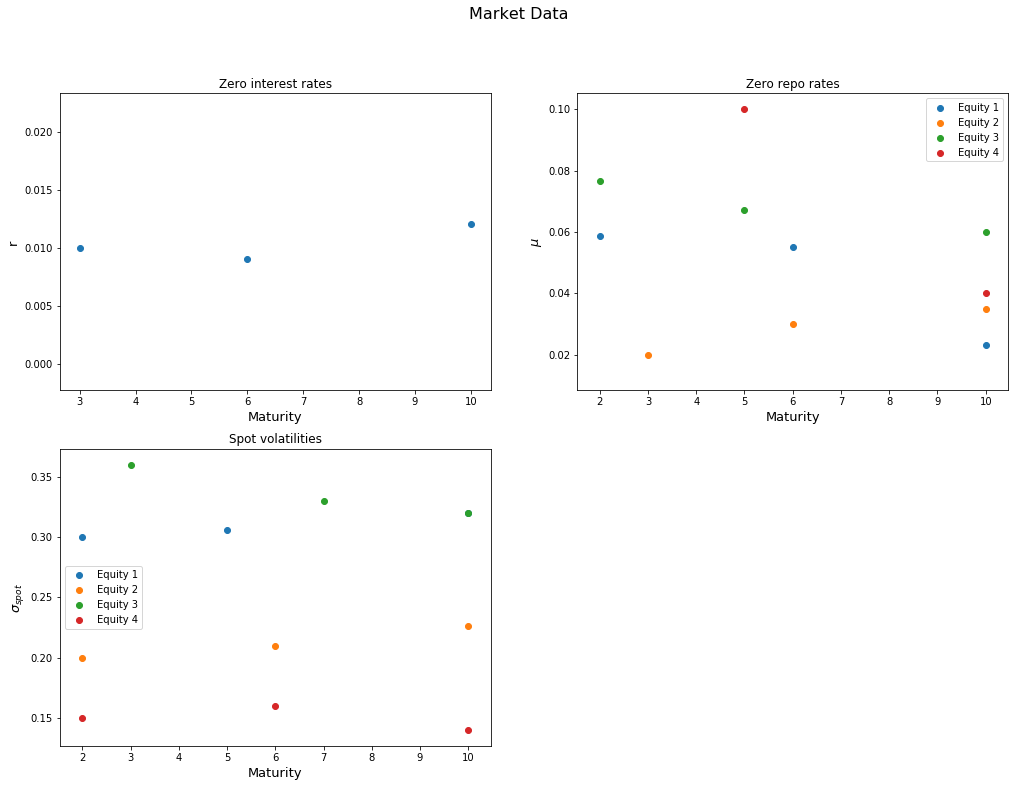

In [11]:
plt.figure(figsize=(17,12))
plt.suptitle('Market Data',fontsize=16) 

plt.subplot(2,2,1)
plt.scatter(T_discounts,r_t)
plt.title('Zero interest rates')
plt.ylabel("r", fontsize = 13)
plt.xlabel("Maturity", fontsize = 13)
#plt.savefig("Zero_interest_rate.pdf")

plt.subplot(2,2,2)
for i in range(N_equity):
    a = globals()["repo_rate" + str(i+1)]
    b = globals()["T_repo" + str(i+1)]
    plt.scatter(b,a,label= "Equity "+str(i+1))
plt.legend()
plt.title('Zero repo rates')
plt.xlabel("Maturity", fontsize = 13)
plt.ylabel(r"$\mu$", fontsize = 13)
#plt.savefig("Zero_repo_rate.pdf")

plt.subplot(2,2,3)
plt.title('Spot volatilities')
for i in range(N_equity):
    strikes = globals()["K" + str(i+1)]
    T = globals()["T_sigma" + str(i+1)]
    spot_volatility = globals()["spot_vola" + str(i+1)]
    spot_vol = interp1d(strikes,spot_volatility,axis=0)(spot_price[i])
    plt.scatter(T,spot_vol,label= "Equity "+str(i+1))
plt.legend()
plt.xlabel("Maturity",fontsize = 13)
plt.ylabel(r"$\sigma_{spot}$",fontsize = 13)
#plt.savefig("spot_volatilities.pdf")
plt.show()

#### Loading Discouting curve, Forward curve and forward variance matrix

In [12]:
D = DiscountingCurve(reference=t, discounts=market_discounts,dates=T_discounts)
F = np.array([])
V = np.array([])
for i in range(N_equity):
    q = globals()["repo_rate" + str(i+1)]
    T_q = globals()["T_repo" + str(i+1)]
    s_vola = globals()["spot_vola" + str(i+1)]
    T_vola = globals()["T_sigma" + str(i+1)]
    K = globals()["K" + str(i+1)]
    F = np.append(F,EquityForwardCurve(reference=t,spot=spot_price[i],discounting_curve=D,repo_dates=T_q,repo_rates=q))
    V = np.append(V,ForwardVariance(reference=t,spot_volatility=s_vola,strikes=K,maturities=T_vola,strike_interp=spot_price[i]))

Forward interest rate time grid [ 3.  6. 10.]
Forward interest rate:  [0.01   0.008  0.0165]
Forward repo time grid [ 2  6 10]
Forward repo rate:  [ 0.05875   0.053125 -0.025   ]
Forward volatility time grid:  [ 2.  5. 10.]
Forward volatility:  [0.3        0.30993548 0.33341266]
Forward repo time grid [ 3.  6. 10.]
Forward repo rate:  [0.02   0.04   0.0425]
Forward volatility time grid:  [ 2.  6. 10.]
Forward volatility:  [0.2        0.21482551 0.24852787]
Forward repo time grid [ 2.  5. 10.]
Forward repo rate:  [0.0767     0.06053333 0.0528    ]
Forward volatility time grid:  [ 3.  7. 10.]
Forward volatility:  [0.36       0.30557323 0.2953529 ]
Forward repo time grid [ 5 10]
Forward repo rate:  [ 0.1  -0.02]
Forward volatility time grid:  [ 2.  6. 10.]
Forward volatility:  [0.15       0.16477257 0.1029563 ]


In [13]:
mu = Drift(F)
nu = CholeskyTDependent(V,corr)

Drift time grid: [ 2.  3.  5.  6. 10.]
Drift values: [[ 0.05875     0.02        0.0767      0.1       ]
 [ 0.053125    0.02        0.06053333  0.1       ]
 [ 0.053125    0.04        0.06053333  0.1       ]
 [ 0.053125    0.04        0.0528     -0.02      ]
 [-0.025       0.0425      0.0528     -0.02      ]]
Cholesky covariance-variance time grid: [ 2.  3.  5.  6.  7. 10.]
Cholesky covariance-variance matrix values: [[[ 0.3         0.30993548  0.30993548  0.33341266  0.33341266
    0.33341266]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0.03        0.03222383  0.03222383  0.03222383  0.03727918
    0.03727918]
  [ 0.1977372   0.21239497  0.21239497  0.21239497  0.24571602
    0.24571602]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
   

In [14]:
alpha = Strategy()
alpha.Mark_strategy(mu=mu,nu=nu)

Markowitz strategy time grid : [ 2.  3.  5.  6.  7. 10.]
Markowitz strategy :  [[-0.28281351  0.13329803 -0.50102447 -6.28758736]
 [-0.24826675  0.11902908 -0.3884439  -5.81004031]
 [-0.16679574 -0.63405091 -0.65477316 -5.51778274]
 [-1.28777052 -2.80864533 -1.82717008  3.71617843]
 [ 0.68209334 -2.62794054 -2.0109217   6.61426604]
 [ 0.67962954 -2.60744444 -2.11597175  6.56884734]]


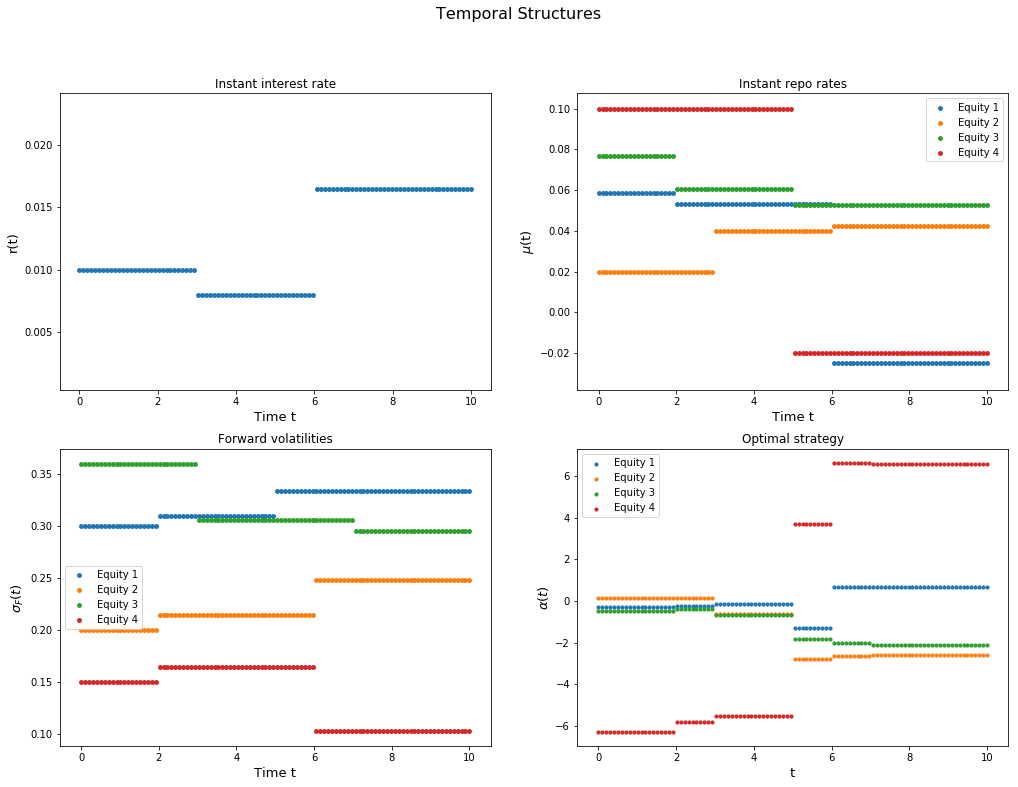

In [24]:
x = np.linspace(0,T_max-0.0001,100)
dimension_points = 15
plt.figure(figsize=(17,12))

plt.suptitle('Temporal Structures',fontsize=16) 

plt.subplot(2,2,1)
plt.scatter(x,piecewise_function(x,D.T,D.r),s=dimension_points)
plt.title('Instant interest rate')
plt.ylabel("r(t)", fontsize = 13)
plt.xlabel("Time t", fontsize = 13)
#plt.savefig("Instant_interest_rate.pdf")


plt.subplot(2,2,2)
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,F[i].T,F[i].q),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.title('Instant repo rates')
plt.xlabel("Time t", fontsize = 13)
plt.ylabel(r"$\mu$(t)", fontsize = 13)
#plt.savefig("Instant_repo_rate.pdf")

plt.subplot(2,2,3)
plt.title('Forward volatilities')
for i in range(N_equity):
    plt.scatter(x,sqrt(V[i](x)),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.xlabel("Time t",fontsize = 13)
plt.ylabel(r"$\sigma_{F}(t)$",fontsize = 13)
#plt.savefig("Forward_volatilities.pdf")

plt.subplot(2,2,4)
plt.title("Optimal strategy")
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,alpha.T,alpha.alpha_t.T[i]),label= "Equity "+str(i+1),s=10)
plt.legend()
plt.xlabel("t",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
#plt.savefig("optimal_strategy.pdf")
plt.show()

#### Simulation

In [25]:
I_0 = np.sum(spot_price)
vol = 0.25
dates = alpha.T
dates = np.delete(dates,len(alpha.T)-1)
dates = np.append(dates,9.9)
K = I_0   #ATM pricing
simulations = 1e6
print("Spot price ",I_0)
print("Dates ",dates)

Spot price  460
Dates  [2.  3.  5.  6.  7.  9.9]


In [26]:
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_mark, result_err_mark = MC_Analisys(pay[:,len(dates)-1],100)

In [9]:
n_grid = 5000    #grid for the integration of the euler method (2600 for 1e6 good)
dates_euler = np.linspace(0.001,9.9,n_grid)

In [10]:
start_time = time.time()
Eulero = TargetVolatilityEuler(reference = 0., vola_target = vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0.,T_max]))
I_t = Eulero.simulate(timegrid = dates_euler,Nsim=simulations, seed=10)
pay_euler = Vanilla_PayOff(St=I_t,strike=K)*D(dates_euler[len(dates_euler)-1])
x, result_euler, result_err_euler = MC_Analisys(pay_euler,100)
print("Execution time: ---%s min ---" %((time.time()-start_time)/60))

0
500
1000
1500
2000
2500
3000
3500
4000
4500
Execution time: ---19.648489900430043 min ---


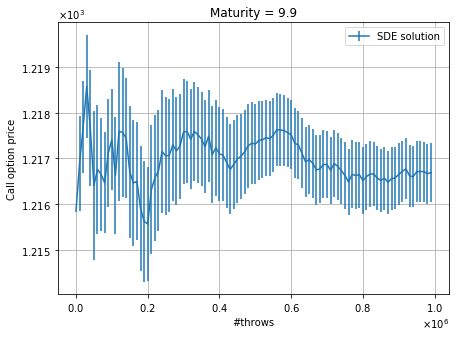

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_mark,yerr=result_err_mark, label = "SDE solution")
plt.errorbar(x,result_euler,yerr=result_err_euler, label = "Eulero method")
plt.xlabel("#throws")
plt.ylabel("Call option price")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
plt.savefig("Markowitz_convergence_with_euler.pdf")
plt.show()

In [27]:
alpha.Intuitive_strategy1(forward_curves=F, maturity_date=T_max)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings= dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive1, result_err_intuitive1 = MC_Analisys(pay[:,len(dates)-1],100)

Strategy time grid:  [ 0 10]
Intuitive strategy (invest all on the asset with maximum growth at maturity)  [[0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [28]:
alpha.Intuitive_strategy2(mu=mu)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive2, result_err_intuitive2 = MC_Analisys(pay[:,len(dates)-1],100)

Strategy time grid:  [ 2.  3.  5.  6. 10.]
Intuitive strategy (invest all on the asset with minimum mu parameter) [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [29]:
alpha.Intuitive_strategy3(mu=mu,nu=nu)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive3, result_err_intuitive3 = MC_Analisys(pay[:,len(dates)-1],100)

Strategy time grid:  [ 2.  3.  5.  6.  7. 10.]
Intuitive strategy (invest all on the asset with minimum mu/||nu|| parameter) [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


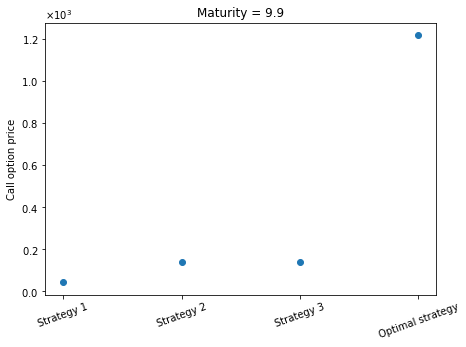

In [33]:
n =len(dates)-1
errori = np.array([result_err_intuitive1[99],result_err_intuitive2[99],result_err_intuitive3[99],result_err_mark[99]])
risultati = err = np.array([result_intuitive1[99],result_intuitive2[99],result_intuitive3[99],result_mark[99]])
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.xticks([1, 2, 3,4], ["Strategy 1","Strategy 2", "Strategy 3", "Optimal strategy"],rotation=20)  # Set text labels and properties.
plt.errorbar([1, 2, 3,4],risultati,errori,fmt='o')
plt.title("Maturity = "+str(round(dates[n],2)))
plt.ylabel("Call option price")
ax.yaxis.set_major_formatter(formatter)
plt.savefig("strategy_comparison.pdf")
plt.show()